과대적합 완화를 위해 드롭아웃 규제 적용

https://github.com/comsa33/NLP-LSTM-emotion_classification/blob/main/N423a_Discussion2.ipynb

# 0) 모듈 실행

##기본 모듈

In [2]:
# Matplotlib 와 pandas 그래프에서 한글 사용 설정
import sys

## 노트북이 코랩에서 실행중인지 체크
if 'google.colab' in sys.modules:
  !echo 'debconf debconf/frontend select Noninterative' | debconf-set-selections
  ## 나눔 폰트 설치
  !sudo apt-get -qq -y install fonts-nanum
  import matplotlib.font_manager as fm
  font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
  for fpath in font_files:
    fm.fontManager.addfont(fpath)

  # 나눔바른고딕 폰트 설정
  import matplotlib.pyplot as plt
  plt.rc('font', family='NanumBarunGothic')
  # 마이너스 기호 표시 오류 수정
  import matplotlib
  matplotlib.rcParams['axes.unicode_minus'] = False


debconf: unable to initialize frontend: Noninterative
debconf: (Can't locate Debconf/FrontEnd/Noninterative.pm in @INC (you may need to install the Debconf::FrontEnd::Noninterative module) (@INC contains: /etc/perl /usr/local/lib/x86_64-linux-gnu/perl/5.34.0 /usr/local/share/perl/5.34.0 /usr/lib/x86_64-linux-gnu/perl5/5.34 /usr/share/perl5 /usr/lib/x86_64-linux-gnu/perl-base /usr/lib/x86_64-linux-gnu/perl/5.34 /usr/share/perl/5.34 /usr/local/lib/site_perl) at (eval 17) line 2, <> line 1.)
debconf: falling back to frontend: Noninteractive
Selecting previously unselected package fonts-nanum.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 모델링

In [4]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 34.1 MB/s eta 0:00:00


In [5]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.3 MB/s eta 0:00:00


In [6]:
import re
import urllib.request
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

In [7]:
from konlpy.tag import Okt

okt = Okt()

In [8]:
from tensorflow.keras.layers import Dense, BatchNormalization, LSTM, Embedding, SimpleRNN, RNN, LSTMCell # 케라스 층 정의
from tensorflow.keras.models import Sequential # 케라스 모델 정의
from tensorflow.keras.preprocessing.text import Tokenizer # 텍스트 데이터 토큰화
from tensorflow.keras.preprocessing import sequence # 시퀀스 데이터 처리

# 1) 데이터 가져오기

## 감성대화 말뭉치
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=86
- 일반인 1,500명 대상의 인터뷰 및 크라우드 소싱 수행
- 우울증 환자 대상 WOZ 대화 수집

=> 전처리 과정으로 "한사람만의 대화를 줄글로 변형 - 질문 제거"

### 1. 데이터 가져오기

In [9]:
train = pd.read_excel("/content/drive/MyDrive/0000/Class/졸프/Dataset/AIhub_감성대화/Training_221115_add/원천데이터/감성대화말뭉치(최종데이터)_Training.xlsx")
test = pd.read_excel("/content/drive/MyDrive/0000/Class/졸프/Dataset/AIhub_감성대화/Validation_221115_add/원천데이터/감성대화말뭉치(최종데이터)_Validation.xlsx")

In [10]:
train_df = train.copy()
test_df = test.copy()

### 2. 전처리

In [11]:
# "사람문장3" 결측값 대체
train_df.fillna('',inplace=True)
test_df.fillna('',inplace=True)

# 문장 병합
train_df['사람문장'] = train_df['사람문장1']+train_df['사람문장2']+train_df['사람문장3']
test_df['사람문장'] = test_df['사람문장1']+test_df['사람문장2']+test_df['사람문장3']

# "감정 분류"과 "문장"만 추출
train_df = train_df[['사람문장', '감정_대분류']]
test_df = test_df[['사람문장', '감정_대분류']]

# 컬럼명 변경
train_df.rename(columns={'사람문장': 'text',
                   '감정_대분류': 'sentiment'}, inplace=True)
test_df.rename(columns={'사람문장': 'text',
                   '감정_대분류': 'sentiment'}, inplace=True)

# label encoding
le = LabelEncoder()
le=le.fit(train_df['sentiment'])
train_df['target']=le.transform(train_df['sentiment'])

le=le.fit(test_df['sentiment'])
test_df['target']=le.transform(test_df['sentiment'])

# text, target
train_conv = train_df[['text','target']]
test_conv = test_df[['text','target']]

<ipython-input-11-f384f47c5c78>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.rename(columns={'사람문장': 'text',
<ipython-input-11-f384f47c5c78>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.rename(columns={'사람문장': 'text',
<ipython-input-11-f384f47c5c78>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['target']=le.transform(train_df['sentiment'])


In [12]:
# 라벨 인코딩 결과 확인
sentiment = train_df[['sentiment', 'target']].drop_duplicates(subset=['sentiment']) # sentiment 컬럼에 대해 중복된 값을 갖고 있는 열 제거
df_unique = sentiment.sort_values(by='target', ascending=True)
df_unique = df_unique.reset_index(drop=True)
df_unique

,sentiment,target
0,기쁨,0
1,당황,1
2,분노,2
3,불안,3
4,상처,4
5,슬픔,5


# 2) 데이터 증강
데이터 불균형으로 인해 분류 전에 전처리하는 방식인 smote 택함

**SMOTE(= Synthetic Minority Over-sampling Technique)**

SMOTE는 합성을 기반으로 하는 방법으로, minority class의 샘플을 가져와 이들을 잇는 선에서 중간값을 택하여 만들어내는 방식

Train

In [13]:
# SMOTE : 오버샘플링
from imblearn.over_sampling import RandomOverSampler
text = train_conv.text.to_numpy().reshape(-1, 1)
target = train_conv.target.to_numpy().reshape(-1, 1)

oversample = RandomOverSampler()

X_oversample, y_oversample = oversample.fit_resample(text, target)
train_conv2 = pd.DataFrame({"text": X_oversample.reshape(-1), 'target': y_oversample.reshape(-1)})
train_conv2

,text,target
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.그냥 내가 해결하는 게 나아. 남들한테...,2
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....,2
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,2
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,2
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.상사인 나에게 먼...,2
...,...,...
55915,평소에는 예의바르고 매너 있는 남자친구가 화나면 폭력적으로 변해서 실망스러워.폭력적...,5
55916,그 사람들이 나의 재산을 보고 나의 친구가 되어 준 것을 알고 너무 슬펐어.내 진정...,5
55917,치료비가 너무 비싸네. 우울해.이 막대한 치료비를 어떻게 충당해야 할지 정말이지 너...,5
55918,우리 아이가 학원에서 과도한 경쟁 때문에 많은 스트레스를 받는 것 같아서 안타까워....,5


Test

In [14]:
# SMOTE : 오버샘플링
from imblearn.over_sampling import RandomOverSampler
text = test_conv.text.to_numpy().reshape(-1, 1)
target = test_conv.target.to_numpy().reshape(-1, 1)

oversample = RandomOverSampler()

X_oversample, y_oversample = oversample.fit_resample(text, target)
test_conv2 = pd.DataFrame({"text": X_oversample.reshape(-1), 'target': y_oversample.reshape(-1)})
test_conv2

,text,target
0,이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 받았어. 너...,3
1,회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워.나에게 너무 크게...,3
2,상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워.무섭게 생겼는데도 업무를 보려면...,3
3,이번에 힘들게 들어간 첫 직장이거든. 첫 직장이라서 그런지 너무 긴장된다.첫 직장이...,3
4,직장에서 동료들이랑 관계가 안 좋아질까 봐 걱정돼.내가 낯가림이 심해서 친해질 수 ...,3
...,...,...
7537,간암으로 간 기증을 기다리면서 희망에는 무뎌지고 좌절에는 익숙해지게 되었어.나에게도...,5
7538,내가 회사에 애정을 가지고 문제점을 건의했는데 위에서 아무도 신경을 안 쓰는 것 같...,5
7539,왜 세상은 내게만 이런 희귀병을 주었는지 모르겠어.이 병은 고칠 수 없는 병인데 앞...,5
7540,이번 주에도 로또에 당첨이 안 됐어.당첨될 확률이 낮지만 그래도 실망스럽긴 해.하다...,5


# 3) 데이터 전처리
모델 적합을 위해 데이터가 적절히 전처리되어야 하며 이때 전처리는 토큰화, 정수 인코딩, 패딩을 의미함

In [58]:
X_train = train_conv2[['text']]
y_train = train_conv2[['target']]

X_test = test_conv2[['text']]
y_test = test_conv2[['target']]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((55920, 1), (55920, 1), (7542, 1), (7542, 1))

In [59]:
from category_encoders import OrdinalEncoder

# 범주형 변수를 정수로 인코딩
enc = OrdinalEncoder()
y_train = enc.fit_transform(y_train['target'])
y_test = enc.fit_transform(y_test['target'])

# 다중 클래스 분류를 위해 원핫 인코딩 수행
import tensorflow as tf
y_train = tf.one_hot(y_train['target'], 6)
y_test = tf.one_hot(y_test['target'], 6)
y_train

<tf.Tensor: shape=(55920, 6), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [60]:
# 한국어 불용어 사전 적용 https://bab2min.tistory.com/544
stopwords = ['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람',
              '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일',
              '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또',
              '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키',
              '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신',
              '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이',
              '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도',
              '좀', '원', '잘', '통하', '소리', '놓']

In [61]:
## 텍스트 전처리 사용자 정의함수(UDF of text pre-processing)
def text_preprocessor(s):
    import re

    ## (1) [], (), {}, <> 괄호와 괄호 안 문자 제거하기
    pattern = r'\([^)]*\)'  # ()
    s = re.sub(pattern=pattern, repl='', string=s)

    pattern = r'\[[^)]*\]'  # []
    s = re.sub(pattern=pattern, repl='', string=s)

    pattern = r'\<[^)]*\>'  # <>
    s = re.sub(pattern=pattern, repl='', string=s)

    pattern = r'\{[^)]*\}'  # {}
    s = re.sub(pattern=pattern, repl='', string=s)

    ## (2) '...외', '...총' 제거하기
    s = s.replace('...외', ' ')
    s = s.replace('...총', ' ')

    ## (3) 특수문자 제거
    pattern = r'[^a-zA-Z가-힣]'
    s = re.sub(pattern=pattern, repl=' ', string=s)

    ## (4) 단위 제거: cm, km, etc.
    units = ['mm', 'cm', 'km', 'ml', 'kg', 'g']
    for unit in units:
        s = s.lower() # 대문자를 소문자로 변환
        s = s.replace(unit, '')

    # (5) 공백 기준으로 분할하기
    s_split = s.split()

    # (6) 글자 1개만 있으면 제외하기
    s_list = []
    for word in s_split:
        if len(word) !=1:
            s_list.append(word)

    return s_list
# 출처: https://rfriend.tistory.com/748 [R, Python 분석과 프로그래밍의 친구 (by R Friend):티스토리]

In [62]:
X_train['text'] = X_train['text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))
X_train['text'] = X_train['text'].apply(lambda s: text_preprocessor(s))
X_train = X_train.text

X_test['text'] = X_test['text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))
X_test['text'] = X_test['text'].apply(lambda s: text_preprocessor(s))
X_test = X_test.text

X_test.head()

<ipython-input-62-9192b2fc5110>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['text'] = X_train['text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))
<ipython-input-62-9192b2fc5110>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['text'] = X_train['text'].apply(lambda s: text_preprocessor(s))
<ipython-input-62-9192b2fc5110>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

0    [이번, 프로젝트에서, 발표를, 하는데, 내가, 실수하는, 바람에, 팀이, 감점을,...
1    [회사에서, 중요한, 프로젝트를, 혼자, 하게, 됐는데, 솔직히, 두렵고, 무서워,...
2    [상사가, 너무, 무섭게, 생겨서, 친해지는, 너무, 두려워, 무섭게, 생겼는데도,...
3    [이번에, 힘들게, 들어간, 직장이거든, 직장이라서, 그런지, 너무, 긴장된다, 직...
4    [직장에서, 동료들이랑, 관계가, 좋아질까, 걱정돼, 내가, 낯가림이, 심해서, 친...
Name: text, dtype: object

전체 샘플의 수 : 55920
단어 집합의 크기 : 110640


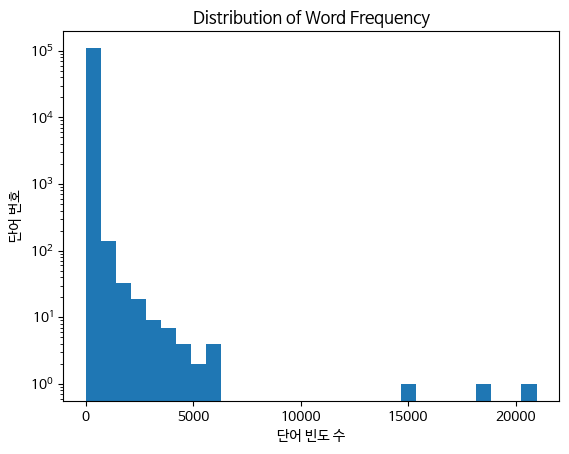

In [63]:
from collections import Counter

# 데이터에서 단어들을 토큰화하여 리스트로 생성
tokenized_words = [word for sentence in X_train for word in sentence]

# 단어들의 빈도를 세고 상위 빈도 단어를 출력
word_counts = Counter(tokenized_words)
print('전체 샘플의 수 : {}'.format(len(X_train)))
print('단어 집합의 크기 : {}'.format(len(word_counts)))

# 시각화
word_freq = list(word_counts.values())

plt.hist(word_freq, bins=30, log=True)
plt.xlabel('단어 빈도 수')
plt.ylabel('단어 번호')
plt.title('Distribution of Word Frequency')
plt.show()

In [64]:
# 단어를 입력하면 빈도수 리턴
# 단어를 키(key)로, 단어에 대한 빈도수가 값(value)으로 저장
word_counts['너무']

20977

In [65]:
# 토큰화 적용
Num_words = 15000 # 데이터에서 가장 빈도가 높은 상위 num_words개의 단어만을 사용하여 토큰화
token = Tokenizer(num_words=Num_words)
token.fit_on_texts(X_train)
print(len(token.word_index))

# 토크나이저를 사용해 입력 텍스트 -> 정수(시퀀스) 변환
X_train_enc = token.texts_to_sequences(X_train)
X_test_enc = token.texts_to_sequences(X_test)

110640


num_words :  Tokenizer의 빈도수에 따라 단어 사전의 갯수를 제한

65
19.410675965665234


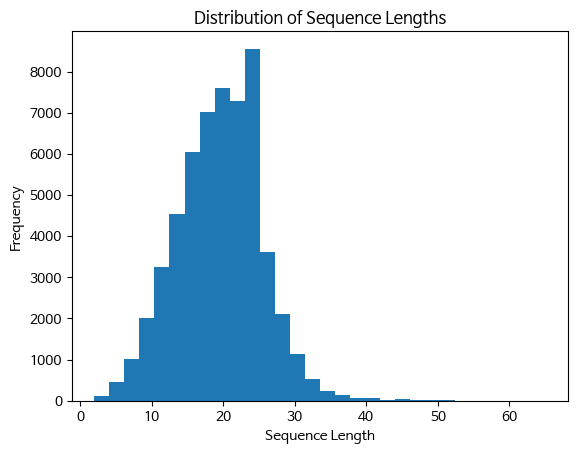

In [66]:
# [시각화] max_len을 찾기 위해 각 시퀀스의 길이를 측정
import matplotlib.pyplot as plt

# 가장 긴 문장
print(max(len(x) for x in X_train_enc))

# 평균 문장
print(np.mean([len(x) for x in X_train_enc]))

# 각 시퀀스의 길이를 측정
sequence_lengths = [len(seq) for seq in X_train_enc]

# 히스토그램으로 시각화
plt.hist(sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [68]:
# [시각화] max_len 을 찾기 위함
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train_enc)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 97.16022889842633


In [69]:
# 패딩: 모든 시퀀스의 길이가 동일해지도록 차원 축소 적용
X_train = sequence.pad_sequences(X_train_enc, max_len, padding='post')
X_train

array([[ 407,  138,  138, ...,    0,    0,    0],
       [  99, 1595, 4916, ...,    0,    0,    0],
       [ 177, 3882, 3805, ...,    0,    0,    0],
       ...,
       [2970,    1,  190, ...,    0,    0,    0],
       [ 365, 5422, 5593, ...,    0,    0,    0],
       [  29, 3373, 3612, ..., 1793,    0,    0]], dtype=int32)

길이가 다른 문장들을 모두 동일한 길이로 바꿔준다
- https://wikidocs.net/64517

In [70]:
# 임베딩할 때 적용, 패딩을 위한 토큰 추가
vocab_size = len(token.word_index) + 1 # 단어 집합의 크기에는 패딩을 위한 토큰을 추가하기 위해 1 더함
vocab_size

110641

# 4) 모델 적합

In [27]:
# https://dacon.io/codeshare/4448
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [87]:
import IPython
import keras_tuner as kt
from tensorflow import keras

tf.random.set_seed(33)

def model_builder(hp):

    output_size = 6
    # 유닛 수 조정
    hp_units = hp.Int('units', min_value = 40, max_value = 96, step = 8)
    hp_units1 = hp.Int('units1', min_value = 40, max_value = 96, step = 8)
    # hp_units2 = hp.Int('units2', min_value = 40, max_value = 96, step = 8)
    # 학습 속도 조정
    # hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2])

    lstm_layer = keras.layers.LSTM(hp_units,
                                   activation='tanh',
                                   dropout=0.5, # 드롭아웃 비율 설정
                                   recurrent_dropout=0.5, # 순환 드롭아웃 비율 설정
                                   recurrent_activation='sigmoid')
    # 모델 구조
    model = keras.models.Sequential(
        [
            keras.layers.Input(shape=(max_len,)), # max_len
            keras.layers.Embedding(vocab_size, 64, input_length=max_len),
             # vocab_size는 토크나이저 선언 시 결정한 단어의 수
             # 64는 vocab_size의 단어를 64차원의 벡터로 임베딩
            lstm_layer, # hp_units
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.5),  # 드롭아웃 비율 설정
            keras.layers.Dense(hp_units1, activation='relu'),
           # keras.layers.Dropout(0.5),  # 드롭아웃 비율 설정
            # keras.layers.Dense(hp_units2, activation='relu'),
            keras.layers.Dense(output_size, activation='softmax'),
        ]
    )

    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy'])
    return model

# 하이퍼파라미터 검색 : 튜닝의 기본 세팅
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', # objective를 최적화하는 방향으로 튜닝
                     max_epochs = 100, # 최적값 찾을 때 모델을 학습하는 최대 에폭
                     factor = 3, # 검색 과정에서 여러 하이퍼파라미터 조합을 제거하는 비율을 결정, 각 반복에서 최상의 성능을 보이지 않는 조합 제거
                     directory = 'my_dir', # 학습 결과 저장
                     project_name = '05_LSTM_result')

# 편의를 위해 학습 시 생긴 로그 삭제하는 클래스
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True) # ipython에 존재하는 이전의 학습 기록 지워줌

# 조기 종료
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                           min_delta=0,
                                           patience=5,
                                           verbose=1)

checkpoint_filepath = "best_a.hdf5"
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None)

# 최적값 검색
tuner.search(X_train, y_train,
             epochs=100,
             batch_size=800,
             callbacks=[ClearTrainingOutput(), early_stop, save_best],
             validation_split=0.15)

Trial 55 Complete [00h 01m 29s]
val_accuracy: 0.6608250141143799

Best val_accuracy So Far: 0.7188841104507446
Total elapsed time: 01h 25m 33s

Search: Running Trial #56

Value             |Best Value So Far |Hyperparameter
96                |72                |units
56                |40                |units1
0.01              |0.01              |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
60/60 [==============================] - ETA: 0s - loss: 1.6045 - accuracy: 0.2935
Epoch 1: val_accuracy improved from -inf to 0.51383, saving model to best_a.hdf5
60/60 [==============================] - 47s 678ms/step - loss: 1.6045 - accuracy: 0.2935 - val_loss: 1.5125 - val_accuracy: 0.5138
Epoch 2/2
11/60 [====>.........................] - ETA: 31s - loss: 1.2740 - accuracy: 0.4767

KeyboardInterrupt: 

In [88]:
# 검색된 최적값 받아오기
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print("최적 유닛 수: {}", "최적 학습속도 {}".format(best_hps.get('units'), best_hps.get("learning_rate")))

최적 유닛 수: {} 최적 학습속도 72


In [89]:
model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 64)            7081024   
                                                                 
 lstm_1 (LSTM)               (None, 72)                39456     
                                                                 
 batch_normalization_1 (Bat  (None, 72)                288       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 72)                0         
                                                                 
 dense_2 (Dense)             (None, 40)                2920      
                                                                 
 dense_3 (Dense)             (None, 6)                 246       
                                                      

In [90]:
# Model fit with the best model
# 최적의 하이퍼파라미터를 이용해 모델 학습
history = model.fit(X_train, y_train,
          epochs=100,
        #  epochs=5,
          batch_size=600,
          callbacks=[early_stop, save_best],
          validation_split=0.20)
history

Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 1.6028 - accuracy: 0.2880
Epoch 1: val_accuracy improved from -inf to 0.44161, saving model to best_a.hdf5
75/75 [==============================] - 42s 488ms/step - loss: 1.6028 - accuracy: 0.2880 - val_loss: 1.5020 - val_accuracy: 0.4416
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 1.2846 - accuracy: 0.4826
Epoch 2: val_accuracy improved from 0.44161 to 0.61195, saving model to best_a.hdf5
75/75 [==============================] - 34s 460ms/step - loss: 1.2846 - accuracy: 0.4826 - val_loss: 1.1957 - val_accuracy: 0.6119
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 1.0654 - accuracy: 0.6133
Epoch 3: val_accuracy improved from 0.61195 to 0.66908, saving model to best_a.hdf5
75/75 [==============================] - 35s 470ms/step - loss: 1.0654 - accuracy: 0.6133 - val_loss: 0.9879 - val_accuracy: 0.6691
Epoch 4/100
75/75 [==============================] - ETA: 0s - loss: 0

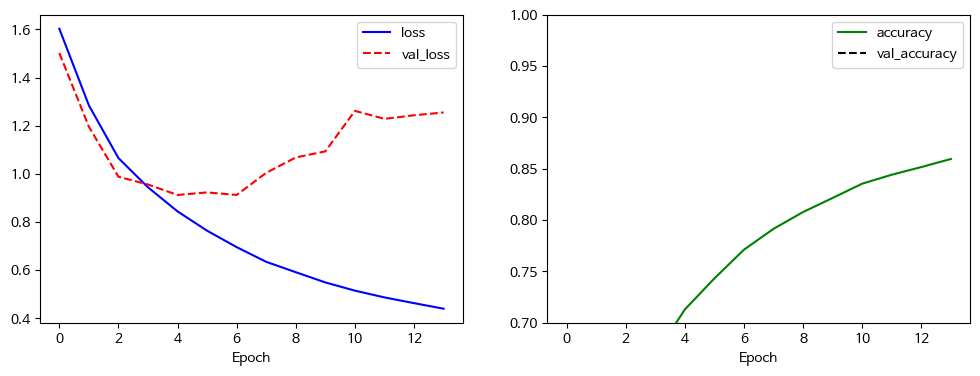

In [91]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

In [92]:
model.load_weights(checkpoint_filepath)

# 5) 모델 test

In [93]:
#X_test_enc = token.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(X_test_enc, maxlen=max_len, padding='post')

#y_test = tf.one_hot(y_test['target'], 6)

In [94]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

236/236 [==============================] - 2s 10ms/step - loss: 1.0698 - accuracy: 0.6945


In [95]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred))

236/236 [==============================] - 5s 21ms/step
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1257
           1       0.65      0.69      0.67      1257
           2       0.72      0.66      0.69      1257
           3       0.67      0.70      0.69      1257
           4       0.56      0.65      0.60      1257
           5       0.70      0.63      0.66      1257

    accuracy                           0.69      7542
   macro avg       0.70      0.69      0.70      7542
weighted avg       0.70      0.69      0.70      7542



<행복>은 비교적 높지만 클래스4인 <상처>는 잘 분류가 되지 않음

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt

index_to_tag = {0 : '기쁨', 1 : '당황', 2 : '분노', 3 : '불안', 4 : '상처', 5 : '슬픔'}

def predict(text, model, tokenizer, index_to_tag, max_seq_length):
    okt = Okt()
    # Tokenize the input text
    tokens = okt.morphs(text) # 토큰화
    token_indices = tokenizer.texts_to_sequences([tokens])  # Convert tokens to indices

    # Pad sequences to have same length as training data
    token_indices = pad_sequences(token_indices, maxlen=max_seq_length, padding='post')

    # Pass the input tensor through the model
    logits = model.predict(token_indices)  # Get model predictions

    # Get the predicted class index
    predicted_index = logits.argmax(axis=1)[0]

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index]

    return predicted_tag

In [ ]:
# Test the function with the given input text
test_input = "오늘은 아침에 일어나자마자 흐린 날씨에 기분이 우울했어요. 하지만 아침 식사를 하고 밖으로 나가니 산뜻한 공기와 바람이 저를 맞이해 기분이 좋아졌어요. \
                머릿속의 부담스러운 생각들이 사라지고, 마음이 가벼워져서 산책을 즐겼어요. \
                오후에는 친구들과의 만남이 있어서 설레고 기대되는 마음으로 하루를 마무리했어요. \
                집으로 돌아와서도 그 행복한 기분이 계속되어 좋은 꿈을 꾸고 있어요."

predicted_tag = predict(test_input, model, token, index_to_tag, 26)
print("Predicted Emotion:", predicted_tag)

#predicted_results = predict_with_prob(test_input, model, token, index_to_tag, 26)
#for tag, prob in predicted_results.items():
 #   print(f"{tag}: {prob * 100:.2f}%")

1/1 [==============================] - 0s 74ms/step
Predicted Emotion: 기쁨


In [ ]:
test_input = "오늘은 마음이 무거워서 힘든 하루였어요. " \
              "뱃속의 작은 생명이 나에게 큰 기쁨을 주고 있지만, 가끔은 불안과 슬픔이 뒤섞여요. 오늘은 그런 날이었어요. " \
              "아이를 향한 사랑과 동시에 부담스러운 책임감이 마음을 무겁게 만들었어요. " \
              "또한, 몸이 불편해서 힘들었고, 아이가 건강하게 태어날까봐 걱정이 많았어요. " \
              "그런데도 아이가 나에게서 받는 사랑과 행복은 모든 것을 잊게 해주는 듯해요. 아이와 함께하는 순간들은 저에게 힘을 주고, 위로가 되어요. " \
              "오늘은 이런 마음을 담아 노래를 듣고 편안한 휴식을 취했어요. 내일은 더 행복한 하루가 될 거라고 믿어요."
predicted_tag = predict(test_input, model, token, index_to_tag, 26)
print("Predicted Emotion:", predicted_tag)

#predicted_results = predict_with_prob(test_input, model, token, index_to_tag, 26)
#for tag, prob in predicted_results.items():
 #   print(f"{tag}: {prob * 100:.2f}%")

1/1 [==============================] - 0s 45ms/step
Predicted Emotion: 기쁨
